# A conclusion about how to train and evaluate a model with detectron2

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

A few steps to train & evaluate a model on a custom dataset with detectron2:
1. Create the json file first. If you want to use the COCOEvaluator, you have to register the metadata attribution [`json_file`](https://detectron2.readthedocs.io/tutorials/datasets.html). 
2. Register the custom dataset and the metadata.
3. Add configs.
4. Override the `build_evaluator()` method if `_C.Test()` is not null.
5. Train.
6. Evaluator.

**The following example use the dataset *tiny_simdata* and the model *tridentNet***

## Create the json file

`json_file` is the annotation json file of the dataset, written in [COCO-format](http://cocodataset.org/#format-data) and used by COCO evaluation.

For **Object Detection** purpose, the file can be lightweighted as the following example(*`area` means segmentation area.*)

In [2]:
{"images":[{"id": 73}],"annotations":[{"image_id":73,"category_id":1,"bbox":[10,10,50,100],"id":1,"iscrowd": 0,"area": 10}],"categories": [{"id": 1, "name": "person"}, {"id": 2, "name": "bicycle"}, {"id": 3, "name": "car"}]}

{'annotations': [{'area': 10,
   'bbox': [10, 10, 50, 100],
   'category_id': 1,
   'id': 1,
   'image_id': 73,
   'iscrowd': 0}],
 'categories': [{'id': 1, 'name': 'person'},
  {'id': 2, 'name': 'bicycle'},
  {'id': 3, 'name': 'car'}],
 'images': [{'id': 73}]}

The **tiny_simdata** use the xml annotation, therefore we write a function to create the json file

In [3]:
%%writefile ./codes/xml2coco.py
from lxml import etree
import json
import os

def xml2coco(data_dir, output_dir = None):
    '''
    Convert the tiny_simdata dataset annotations into a COCO format ground truth json file so as to call COCOEvaluator
    Args:
        data_dir(string): the path of the dataset which stores the pictures and annitations, e.g. 'tiny_simdata/val'
        output_dir(string): the directory to save the json file
    '''
    xml_files=os.listdir(os.path.join(data_dir,'Annotations'))
    
    json_anno = {}
    
    categories = [{'id': 2, 'name': 'gun'}, {'id':17, 'name': 'lighter'}]
#     for i in range(78):
#         cat = {}
#         cat['id'] = i+80
#         cat['name'] = str(i)+'aaaa'
#         categories.append(cat)
    json_anno['categories'] = categories
    
    images = []
    annotations = []
    
    anno_id = 0
    for file in xml_files:
        # becasue I'm using Jupyterlab
        # which always creates the boring file/directory
        if file == '.ipynb_checkpoints':
            continue
        img_record = {}
        
        img_record['width'] = 190     # optional for object detection
        img_record['height'] = 380     # optional for object detection
             
        tree=etree.parse(os.path.join(data_dir,'Annotations',file))
        root=tree.getroot()
        bboxes=[]
        for c in root.iter():
            if c.tag == 'filename':
                filename = c.text
                image_id = ''
                for i in filter(str.isdigit, filename):
                    image_id += i
                img_record['filename'] = filename
                img_record['id']=int(image_id)
            if c.tag=='bndbox':
                bboxes.append(c)
                
        for bbox in bboxes:
            anno_record ={}
            anno_record['id'] = anno_id
            anno_id += 1
            anno_record['image_id'] = img_record['id']
            anno_record['category_id'] = int(filename[:3])
            anno_record['iscrowd'] = 0
            box=[]
            for b in bbox.iterchildren():
                box.append(int(b.text))
            x = (box[0] + box[2])/2
            y = (box[1] + box[3])/2
            assert(box[2] > box[0])
            assert(box[3] > box[1])
            width = box[2] - box[0]
            height = box[3] - box[1]
            anno_record['bbox'] = [x, y, width, height]
            anno_record['area'] = float(width*height)
            annotations.append(anno_record)
        images.append(img_record)

    json_anno['images'] = images
    json_anno['annotations'] = annotations
    
    json_file = json.dumps(json_anno)
    if output_dir == None:
        output_dir = data_dir
    with open(os.path.join(output_dir,'annotations.json'),'w') as f:
        f.write(json_file)

Overwriting ./codes/xml2coco.py


In [4]:
from codes.xml2coco import xml2coco
xml2coco('tiny_simdata/val')

## Register the custom dataset and the metadata

To let detectron2 know how to obtain a custom dataset, you will implement a function that returns the items in your dataset and then tell detectron2 about this function. The dict may have the fields mentioned [here](https://detectron2.readthedocs.io/tutorials/datasets.html)

In [5]:
%%writefile ./codes/get_tinysim.py
from detectron2.structures import BoxMode
from lxml import etree
import os

def get_tinysim(data_dir):
    '''
    Convert the dataset annotations into a format which detectron2 can accept and register
    Args:
        data_dir(string): the path of the dataset which stores the pictures and annitations, e.g. 'simImage/val'
    Returns:
        list[dict]: in the required format as declared in https://detectron2.readthedocs.io/tutorials/datasets.html
    '''
    xml_files=os.listdir(os.path.join(data_dir,'Annotations'))
    dataset_dicts=[]
    for file in xml_files:
        if file == '.ipynb_checkpoints':
            continue
        record={}
        tree=etree.parse(os.path.join(data_dir,'Annotations',file))
        root=tree.getroot()
        tags=[]
        texts=[]
        bboxes=[]
        for c in root.iter():
            tags.append(c.tag)
            texts.append(c.text)
            if c.tag=='bndbox':
                bboxes.append(c)
        filename = texts[tags.index('filename')]
        image_id = ''
        for i in filter(str.isdigit, filename):
            image_id += i
        record['image_id']=int(image_id)
        record['file_name']=os.path.join(data_dir,filename)
        record['width']=int(texts[tags.index('width')])     # optional for object detection
        record['height']=int(texts[tags.index('height')])   # optional for object detection
        if int(filename[:3]) == 2:
            category_id = 0
        else:
            category_id = 1
        objs=[]
        for bbox in bboxes:
            box=[]
            for b in bbox.iterchildren():
                box.append(int(b.text))
            assert(box[2]>box[0])
            assert(box[3]>box[1])
            obj={
                'bbox':box,
                'bbox_mode':BoxMode.XYXY_ABS,
                'category_id':category_id,
#                 'iscrowd':0,    # optional for object detection
            }
            objs.append(obj)
        record['annotations']=objs
        dataset_dicts.append(record)
    return dataset_dicts

Overwriting ./codes/get_tinysim.py


In [6]:
from codes.get_tinysim import get_tinysim
from detectron2.data import DatasetCatalog, MetadataCatalog

for d in ['train','val']:
    DatasetCatalog.register('tiny_simdata/'+d, lambda d = d: get_tinysim('tiny_simdata/'+d))
#     DatasetCatalog.get('tiny_simdata/'+d)
#     MetadataCatalog.get('tiny_simdata/'+d).set(thing_classes=\
#                                                ['gun','lighter','3aaaa','4aaaa','5aaaa','6aaaa','7aaaa','8aaaa','9aaaa','10aaaa','11',\
#                                                 '12aaaa','13','14','15','16','17','18','19','20aaaa','21','22aaaa','23','24aaaa',\
#                                                '25aaaa','26','27','28','29','30aaaa','31','32','33aaaa','34','35','36','37','38',\
#                                                 '39aaaa','40','41','42aaaa','43','44aaaa','45aaaa','46','47aaaa','48','49','50','51','52',\
#                                                '53aaaa','54','55','56aaaa','57','58aaaa','59','60aaaa','61','62aaaa','63','64','65','66',\
#                                                '67aaaa','68aaaa','69','70','71','72aaaa','73','74','75','76','77aaaa','78','79','80'])
    MetadataCatalog.get('tiny_simdata/'+d).set(thing_classes=['gun','lighter'])
    MetadataCatalog.get('tiny_simdata/'+d).set(json_file='tiny_simdata/'+d+'/annotations.json')
object_metadata=MetadataCatalog.get('tiny_simdata/train') 

In [7]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("tiny_sim", {}, "json_annotation.json", "path/to/image/dir")

## Add configs

In [8]:
%run ./codes/default_argument_parser_detectron2.py \
--config-file='../projects/TridentNet/configs/tridentnet_fast_R_50_C4_1x.yaml' \
SOLVER.IMS_PER_BATCH 1 SOLVER.BASE_LR 0.0025

In [9]:
from detectron2.config import get_cfg
from projects.TridentNet.tridentnet import add_tridentnet_config
cfg = get_cfg()
add_tridentnet_config(cfg)
cfg.merge_from_file(args.config_file)
cfg.DATASETS.TRAIN = ('tiny_simdata/train',)
cfg.DATASETS.TEST = ('tiny_simdata/val',)
cfg.SOLVER.MAX_ITER = 2000
cfg.merge_from_list(args.opts)

Config '../projects/TridentNet/configs/tridentnet_fast_R_50_C4_1x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [10]:
cfg.freeze()

## Train

In [11]:
from detectron2.engine import default_setup
default_setup(cfg, args)

[11/26 07:15:03 detectron2]: Rank of current process: 0. World size: 1
[11/26 07:15:03 detectron2]: Environment info:
------------------------  --------------------------------------------------
sys.platform              linux
Python                    3.6.8 (default, Oct  7 2019, 12:59:55) [GCC 8.3.0]
Numpy                     1.13.3
Detectron2 Compiler       GCC 7.4
Detectron2 CUDA Compiler  10.1
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.3.0
PyTorch Debug Build       False
torchvision               0.4.1
CUDA available            True
GPU 0                     GeForce GTX 1060 6GB
CUDA_HOME                 /usr/local/cuda
NVCC                      Cuda compilation tools, release 10.1, V10.1.243
Pillow                    6.2.0
cv2                       3.2.0
------------------------  --------------------------------------------------
PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architectu

In [12]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, verify_results
from detectron2.checkpoint import DetectionCheckpointer

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

In [13]:
trainer = Trainer(cfg)

[11/26 07:15:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

In [14]:
trainer.resume_or_load(resume=args.resume)
# trainer.resume_or_load(resume=True)

[11/26 07:15:07 fvcore.common.checkpoint]: Loading checkpoint from detectron2://ImageNetPretrained/MSRA/R-50.pkl
[11/26 07:15:07 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/ImageNetPretrained/MSRA/R-50.pkl cached in /root/.torch/fvcore_cache/detectron2/ImageNetPretrained/MSRA/R-50.pkl
[11/26 07:15:07 d2.checkpoint.c2_model_loading]: Remapping C2 weights ......
[11/26 07:15:07 d2.checkpoint.c2_model_loading]: backbone.res2.0.conv1.norm.bias                      loaded from res2_0_branch2a_bn_beta           of shape (64,)
[11/26 07:15:07 d2.checkpoint.c2_model_loading]: backbone.res2.0.conv1.norm.running_mean              loaded from res2_0_branch2a_bn_running_mean   of shape (64,)
[11/26 07:15:07 d2.checkpoint.c2_model_loading]: backbone.res2.0.conv1.norm.running_var               loaded from res2_0_branch2a_bn_running_var    of shape (64,)
[11/26 07:15:07 d2.checkpoint.c2_model_loading]: backbone.res2.0.conv1.norm.weight                    loaded from res2_0_b

In [15]:
trainer.train()

[11/26 07:15:07 d2.engine.train_loop]: Starting training from iteration 0
[11/26 07:15:32 d2.utils.events]: eta: 0:41:54  iter: 19  total_loss: 4.039  loss_cls: 3.345  loss_box_reg: 0.000  loss_rpn_cls: 0.674  loss_rpn_loc: 0.008  time: 1.2688  data_time: 0.0013  lr: 0.000050  max_mem: 2378M
[11/26 07:15:58 d2.utils.events]: eta: 0:41:29  iter: 39  total_loss: 0.650  loss_cls: 0.002  loss_box_reg: 0.000  loss_rpn_cls: 0.625  loss_rpn_loc: 0.009  time: 1.2649  data_time: 0.0014  lr: 0.000100  max_mem: 2378M
[11/26 07:16:23 d2.utils.events]: eta: 0:41:07  iter: 59  total_loss: 0.516  loss_cls: 0.000  loss_box_reg: 0.000  loss_rpn_cls: 0.486  loss_rpn_loc: 0.005  time: 1.2650  data_time: 0.0014  lr: 0.000150  max_mem: 2378M
[11/26 07:16:49 d2.utils.events]: eta: 0:40:44  iter: 79  total_loss: 0.313  loss_cls: 0.000  loss_box_reg: 0.000  loss_rpn_cls: 0.305  loss_rpn_loc: 0.005  time: 1.2703  data_time: 0.0014  lr: 0.000200  max_mem: 2378M
[11/26 07:17:14 d2.utils.events]: eta: 0:40:16  it

OrderedDict([('bbox',
              {'AP': 0.0,
               'AP-gun': 0.0,
               'AP-lighter': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APl': -100.0,
               'APm': 0.0,
               'APs': 0.0})])

## Evaluate

In [30]:
from detectron2.engine import DefaultPredictor

cfg.defrost()
cfg.MODEL.WEIGHTS=os.path.join(cfg.OUTPUT_DIR,'model_final.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.75
predictor = DefaultPredictor(cfg)

[11/26 09:07:12 fvcore.common.checkpoint]: Loading checkpoint from ./output/model_final.pth


added by chizao
Instances(num_instances=2, image_height=380, image_width=190, fields=[pred_boxes, scores, pred_classes])
added ends here
added by chizao
['lighter 93%', 'lighter 83%']
added ends here
added by chizao
Instances(num_instances=0, image_height=380, image_width=190, fields=[pred_boxes, scores, pred_classes])
added ends here
added by chizao
[]
added ends here
added by chizao
Instances(num_instances=2, image_height=380, image_width=190, fields=[pred_boxes, scores, pred_classes])
added ends here
added by chizao
['lighter 86%', 'lighter 81%']
added ends here
added by chizao
Instances(num_instances=1, image_height=380, image_width=190, fields=[pred_boxes, scores, pred_classes])
added ends here
added by chizao
['lighter 80%']
added ends here


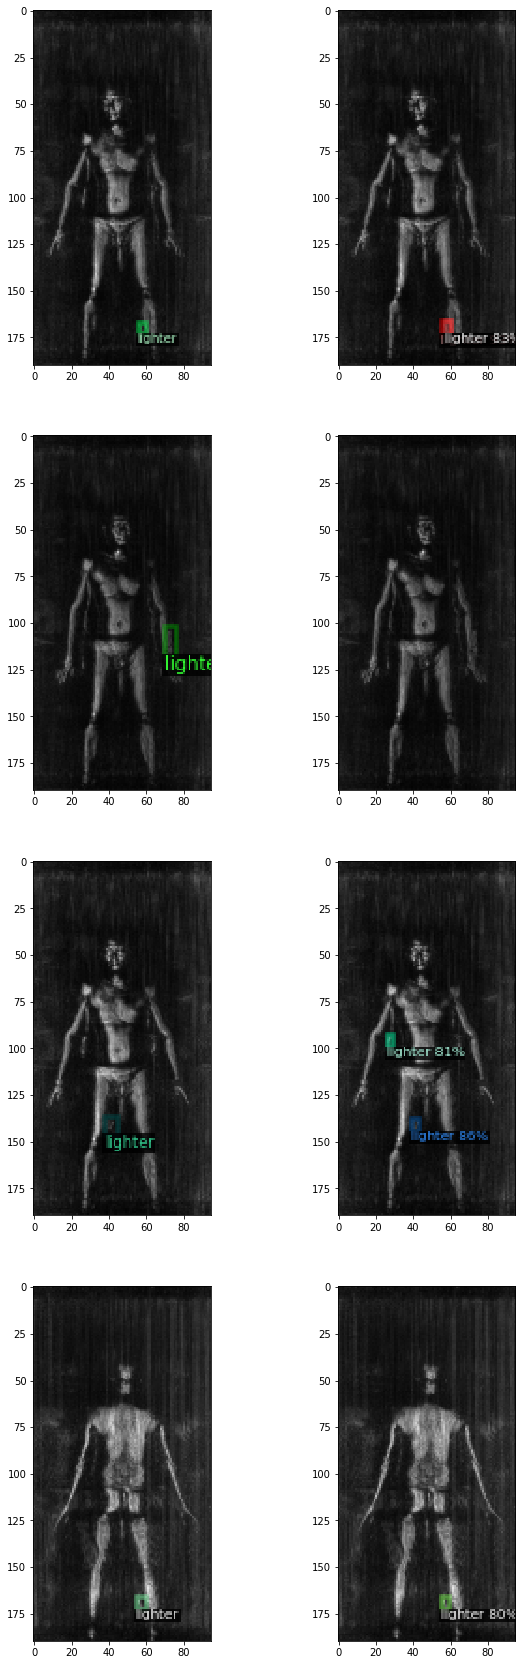

In [32]:
# from detectron2.utils.visualizer import ColorMode
import random
from detectron2.utils.visualizer import Visualizer
from matplotlib import pyplot as plt
import numpy as np
import cv2

dataset_dicts = get_tinysim('tiny_simdata/val')
i=1
plt.figure(figsize=(10,30))
for d in random.sample(dataset_dicts, 4):
    im = cv2.imread(d['file_name'])
    outputs = predictor(im)
#     print(outputs)
    v = Visualizer(im[:,:,::-1],
                   metadata=object_metadata,
                   scale=0.5
    )
    vis = Visualizer(im[:,:,::-1],
                   metadata=object_metadata,
                   scale=0.5
    )
    v = v.draw_dataset_dict(d)
    vis = vis.draw_instance_predictions(outputs['instances'].to('cpu'))
    plt.subplot(4,2,i)
    plt.imshow(v.get_image()[:,:,::-1])
    plt.subplot(4,2,i+1)
    plt.imshow(vis.get_image()[:,:,::-1])
    i += 2